## Notebook for gathering final results from UKB external validation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

In [4]:
#from folder testsplits/testsplits_100_24_10, get all phecodes, which are present as filenames after string "testsplits_phecode" but before ".csv" and store them in a list
phecodes_disease_onset = []
for file in glob.glob("../testsplits/testsplits_100_0_1/testsplits_phecode*.csv"):
    phecodes_disease_onset.append(file.split("testsplits_")[2].split(".csv")[0])

print(phecodes_disease_onset)

['phecode_RE_468', 'phecode_CV_404.1', 'phecode_MS_705.1', 'phecode_MS_718', 'phecode_RE_474', 'phecode_CV_431.11', 'phecode_CV_440.3', 'phecode_EM_202', 'phecode_GU_582.2', 'phecode_MB_284', 'phecode_CV_410.2', 'phecode_CV_413.11', 'phecode_CV_438.11', 'phecode_DE_664.4', 'phecode_CV_404', 'phecode_NS_324.11', 'phecode_CV_400', 'phecode_CV_413.21', 'phecode_CV_420', 'phecode_BI_164', 'phecode_CV_401', 'phecode_CV_424']


In [5]:
indications = dict(
    disease_onset = phecodes_disease_onset, #['phecode_GU_615', 'phecode_MS_705', 'phecode_CA_121.11', 'phecode_MS_700.3', 'phecode_GU_591'],
    hospitalization = ["admin_hospital"],
    death = ["admin_death"]
)
cases = ['0-1']  #['0-1', '24-10'] 
balanced = ['_balanced_'] #["_", '_balanced_']
# further cases: balanced / unbalanced

# Processing of tables from all different diseases

In [6]:
all_scores = []

# Calculate global min and max for y-axis
global_min = float('inf')
global_max = float('-inf')

dataset = 'bigdataset' #'rawdataset' #
num_cv_rounds = 10 #25

# Loop through diseases and cases to load CSVs and find min/max
for indication, phecodelist in indications.items():
    for disease in phecodelist:
        for balancedness in balanced:
            for case in cases:
                #scores_filename = f"../tables/table_{case}_{disease}_nocalcembed_*.csv"
                scores_filename = f"../tables/{indication}/table_{dataset}{balancedness}gbm_dates_query_{disease}_*_runall_{num_cv_rounds}_diseaseunspecific_{case}_balancedtestset.csv"
                matching_files = glob.glob(scores_filename)
                
                if(len(matching_files) == 0):
                    print(f"Skipping {disease} {case} {balancedness}")
                    continue
                # Load the CSV#
                scores = pd.read_csv(matching_files[0])
                scores['disease'] = disease
                scores['case'] = case
                scores['balanced'] = balancedness

                columns_noauroc = [c for c in scores.columns if 'auroc' not in c]

                scores_llm2vec = scores[columns_noauroc + ['auroc_llm2vec']].copy()
                scores_llm2vec.rename(columns={'auroc_llm2vec': 'auroc'}, inplace=True)
                scores_llm2vec['model'] = "LLM2Vec"

                scores_qwen = scores[columns_noauroc + ['auroc_qwen']].copy()
                scores_qwen.rename(columns={'auroc_qwen': 'auroc'}, inplace=True)
                scores_qwen['model'] = "Qwen"

                # scores_nvembed = scores[columns_noauroc + ['auroc_nvembed']].copy()
                # scores_nvembed.rename(columns={'auroc_nvembed': 'auroc'}, inplace=True)
                # scores_nvembed['model'] = "NVEmbed"

                scores_clmbr = scores[columns_noauroc + ['auroc_clmbr']].copy()
                scores_clmbr.rename(columns={'auroc_clmbr': 'auroc'}, inplace=True)
                scores_clmbr['model'] = "CLMBR"

                scores_counts = scores[columns_noauroc + ['auroc_counts']].copy()
                scores_counts.rename(columns={'auroc_counts': 'auroc'}, inplace=True)
                scores_counts['model'] = 'counts'

                # scores_agesex = scores[columns_noauroc + ['auroc_agesex']].copy()
                # scores_agesex.rename(columns={'auroc_agesex': 'auroc'}, inplace=True)
                # scores_agesex['model'] = 'agesex'

                #scores = pd.concat([scores_llm2vec, scores_qwen, scores_nvembed, scores_clmbr, scores_counts])
                scores = pd.concat([scores_llm2vec, scores_qwen, scores_clmbr, scores_counts])


                all_scores.append(scores)

all_scores = pd.concat(all_scores)
all_scores

sample_size  crossval_iteration  patnum_train  auprc_llm2vec  auprc_qwen  \
0           256                   0           256       0.739293    0.753147   
1           256                   1           256       0.751639    0.771421   
2           256                   2           256       0.745057    0.783292   
3           256                   3           256       0.737495    0.769339   
4           256                   4           256       0.752023    0.780601   
..          ...                 ...           ...            ...         ...   
85            1                   5             1       0.568157    0.750000   
86            1                   6             1       0.562808    0.684088   
87            1                   7             1       0.589992    0.750000   
88            1                   8             1       0.495571    0.751742   
89            1                   9             1       0.633401    0.753484   

    auprc_clmbr  auprc_counts  auprc_agesex  testpatnum         disease case  \
0      0.740180      0.724704      0.629429         295  phecode_RE_468  0-1   
1      0.758398      0.747584      0.663637         295  phecode_RE_468  0-1   
2      0.768357      0.723875      0.600534         295  phecode_RE_468  0-1   
3      0.771188      0.713684      0.643910         295  phecode_RE_468  0-1   
4      0.755373      0.729624      0.671263         295  phecode_RE_468  0-1   
..          ...           ...           ...         ...             ...  ...   
85     0.621714      0.602134      0.559417         287     admin_death  0-1   
86     0.653115      0.674727      0.653386         287     admin_death  0-1   
87     0.550369      0.528260      0.620879         287     admin_death  0-1   
88     0.575183      0.730223      0.383546         287     admin_death  0-1   
89     0.586006      0.759582      0.445772         287     admin_death  0-1   

      balanced     auroc    model  
0   _balanced_  0.745303  LLM2Vec  
1   _balanced_  0.746004  LLM2Vec  
2   _balanced_  0.737799  LLM2Vec  
3   _balanced_  0.738248  LLM2Vec  
4   _balanced_  0.744740  LLM2Vec  
..         ...       ...      ...  
85  _balanced_  0.534843   counts  
86  _balanced_  0.496516   counts  
87  _balanced_  0.489547   counts  
88  _balanced_  0.527875   counts  
89  _balanced_  0.519164   counts  

[7600 rows x 14 columns]

In [7]:
#only keeps rows where crossval_iteration is between 0 and 4
all_scores = all_scores[all_scores['crossval_iteration'].isin([0, 1, 2, 3, 4])]
all_scores

sample_size  crossval_iteration  patnum_train  auprc_llm2vec  auprc_qwen  \
0           256                   0           256       0.739293    0.753147   
1           256                   1           256       0.751639    0.771421   
2           256                   2           256       0.745057    0.783292   
3           256                   3           256       0.737495    0.769339   
4           256                   4           256       0.752023    0.780601   
..          ...                 ...           ...            ...         ...   
80            1                   0             1       0.564293    0.250000   
81            1                   1             1       0.469958    0.750000   
82            1                   2             1       0.609295    0.753484   
83            1                   3             1       0.593340    0.750000   
84            1                   4             1       0.539788    0.539199   

    auprc_clmbr  auprc_counts  auprc_agesex  testpatnum         disease case  \
0      0.740180      0.724704      0.629429         295  phecode_RE_468  0-1   
1      0.758398      0.747584      0.663637         295  phecode_RE_468  0-1   
2      0.768357      0.723875      0.600534         295  phecode_RE_468  0-1   
3      0.771188      0.713684      0.643910         295  phecode_RE_468  0-1   
4      0.755373      0.729624      0.671263         295  phecode_RE_468  0-1   
..          ...           ...           ...         ...             ...  ...   
80     0.529299      0.745635      0.442415         287     admin_death  0-1   
81     0.421180      0.584984      0.675121         287     admin_death  0-1   
82     0.473911      0.521359      0.431286         287     admin_death  0-1   
83     0.670971      0.603633      0.704840         287     admin_death  0-1   
84     0.591957      0.672474      0.636558         287     admin_death  0-1   

      balanced     auroc    model  
0   _balanced_  0.745303  LLM2Vec  
1   _balanced_  0.746004  LLM2Vec  
2   _balanced_  0.737799  LLM2Vec  
3   _balanced_  0.738248  LLM2Vec  
4   _balanced_  0.744740  LLM2Vec  
..         ...       ...      ...  
80  _balanced_  0.496516   counts  
81  _balanced_  0.470383   counts  
82  _balanced_  0.494774   counts  
83  _balanced_  0.531359   counts  
84  _balanced_  0.500000   counts  

[3800 rows x 14 columns]

In [158]:
#For checking low values of counts method in mortality prediction at sample size up to 16
all_scores[(all_scores['model'] == 'counts') & (all_scores['disease_group'] == 'admin_death')].head()

sample_size  crossval_iteration  patnum_train  auprc_llm2vec  auprc_qwen  \
0          256                   0           256       0.776260    0.837304   
1          256                   1           256       0.791328    0.834546   
2          256                   2           256       0.758452    0.804517   
3          256                   3           256       0.754532    0.805081   
4          256                   4           256       0.807546    0.841432   

   auprc_clmbr  auprc_counts  auprc_agesex  testpatnum      disease case  \
0     0.810743      0.682593      0.627130         287  admin_death  0-1   
1     0.770490      0.701384      0.687006         287  admin_death  0-1   
2     0.782830      0.662239      0.625317         287  admin_death  0-1   
3     0.766073      0.737799      0.648551         287  admin_death  0-1   
4     0.825310      0.731773      0.693945         287  admin_death  0-1   

     balanced     auroc   model disease_group  
0  _balanced_  0.643343  counts   admin_death  
1  _balanced_  0.667909  counts   admin_death  
2  _balanced_  0.653134  counts   admin_death  
3  _balanced_  0.706807  counts   admin_death  
4  _balanced_  0.725291  counts   admin_death

In [5]:
all_scores.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({
        'auroc': 'mean',
    }).reset_index()

sample_size  crossval_iteration    model     auroc
0              1                   0    CLMBR  0.560574
1              1                   0  LLM2Vec  0.524395
2              1                   0     Qwen  0.501798
3              1                   0   counts  0.512033
4              1                   1    CLMBR  0.528593
..           ...                 ...      ...       ...
895          256                  23   counts  0.705249
896          256                  24    CLMBR  0.794806
897          256                  24  LLM2Vec  0.794121
898          256                  24     Qwen  0.817578
899          256                  24   counts  0.701755

[900 rows x 4 columns]

In [8]:
model_name = {
    "Qwen": "GTE Qwen2 7B+LR",
    "LLM2Vec": "LLM2Vec Llama 3.1 8B+LR",
    "CLMBR": "CLMBR+LR",
    "counts": "Count based+GBM",
}

model_palette = {
    "GTE Qwen2 7B+LR": "#ff7f0e",           # orange
    "LLM2Vec Llama 3.1 8B+LR": "#2ca02c",   # green
    "CLMBR+LR": "#1f77b4",                  # blue
    "Count based+GBM": "#d62728",          # red
}

# Define different markers for each model
model_markers = {
    "CLMBR+LR": "X",
    "Count based+GBM": "p",
    "GTE Qwen2 7B+LR": "o",
    "LLM2Vec Llama 3.1 8B+LR": "o"
}

task_mapping = {
    "disease_onset": "Disease onset",
    "admin_hospital": "Hospitalization onset",
    "admin_death": "Mortality prediction",
}

selected_diseases = {"admin_death", "admin_hospital"}

In [9]:
# Filter for sample size = 128
filtered_scores = all_scores[all_scores["sample_size"] == 256].copy()

# Apply mappings
filtered_scores["model"] = filtered_scores["model"].map(model_name)
filtered_scores["disease_group"] = filtered_scores["disease"].apply(
    lambda x: x if x in selected_diseases else "disease_onset"
)
filtered_scores["disease_group"] = filtered_scores["disease_group"].map(task_mapping)

# Group and calculate statistics
agg = (
    filtered_scores
    .groupby(["model", "disease_group"])["auroc"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)

# Compute 95% Confidence Interval
agg["sem"] = agg["std"] / np.sqrt(agg["count"])          # Standard Error of the Mean
agg["ci95"] = 1.96 * agg["sem"]                          # 95% CI range
agg["ci_lower"] = agg["mean"] - agg["ci95"]
agg["ci_upper"] = agg["mean"] + agg["ci95"]

# Round for readability
agg[["mean", "ci_lower", "ci_upper"]] = agg[["mean", "ci_lower", "ci_upper"]].round(3)

# Format into string: mean (lower–upper)
agg["auroc_formatted"] = agg.apply(
    lambda row: f"{row['mean']:.3f} ({row['ci_lower']:.3f}–{row['ci_upper']:.3f})", axis=1
)

# Define the desired model order based on model_name values
model_order = list(model_name.values())

# Set 'model' as a categorical type with desired order
agg["model"] = pd.Categorical(agg["model"], categories=model_order, ordered=True)

# Pivot to wide format
pretty_table = agg.pivot(index="model", columns="disease_group", values="auroc_formatted")


# Create a numerical version of the pivot table to calculate means
numerical_pivot = agg.pivot(index="model", columns="disease_group", values="mean")

# Calculate the mean across the three columns
mean_across_columns = numerical_pivot.mean(axis=1).round(3)

# Get the corresponding CI values for each task and model
ci_data = agg.pivot_table(index="model", columns="disease_group", values=["ci_lower", "ci_upper"])

# Calculate average CI boundaries
avg_ci_lower = ci_data["ci_lower"].mean(axis=1).round(3)
avg_ci_upper = ci_data["ci_upper"].mean(axis=1).round(3)

# Create the formatted string for the mean column
mean_formatted = pd.DataFrame({
    "Mean Across Tasks": [f"{mean:.3f} ({lower:.3f}–{upper:.3f})" 
                         for mean, lower, upper in zip(mean_across_columns, avg_ci_lower, avg_ci_upper)]
}, index=mean_across_columns.index)

# Join with the original table
pretty_table = pretty_table.join(mean_formatted)

# Ensure the same model order
pretty_table = pretty_table.reindex(model_order)

# Display the result
pretty_table

/tmp/ipykernel_1669373/3465401336.py:50: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ci_data = agg.pivot_table(index="model", columns="disease_group", values=["ci_lower", "ci_upper"])


Disease onset Hospitalization onset  \
model                                                                
GTE Qwen2 7B+LR          0.837 (0.818–0.857)   0.616 (0.607–0.626)   
LLM2Vec Llama 3.1 8B+LR  0.820 (0.799–0.840)   0.600 (0.583–0.616)   
CLMBR+LR                 0.812 (0.792–0.832)   0.611 (0.603–0.619)   
Count based+GBM          0.821 (0.797–0.844)   0.583 (0.570–0.595)   

                        Mortality prediction    Mean Across Tasks  
model                                                              
GTE Qwen2 7B+LR          0.806 (0.789–0.823)  0.753 (0.738–0.769)  
LLM2Vec Llama 3.1 8B+LR  0.776 (0.763–0.790)  0.732 (0.715–0.749)  
CLMBR+LR                 0.780 (0.767–0.793)  0.734 (0.721–0.748)  
Count based+GBM          0.721 (0.701–0.741)  0.708 (0.689–0.727)

In [44]:
all_scores["disease_group"] = all_scores["disease"].apply(
    lambda x: x if x in selected_diseases else "disease_onset"
)

/tmp/ipykernel_2902099/2632152028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_scores["disease_group"] = all_scores["disease"].apply(


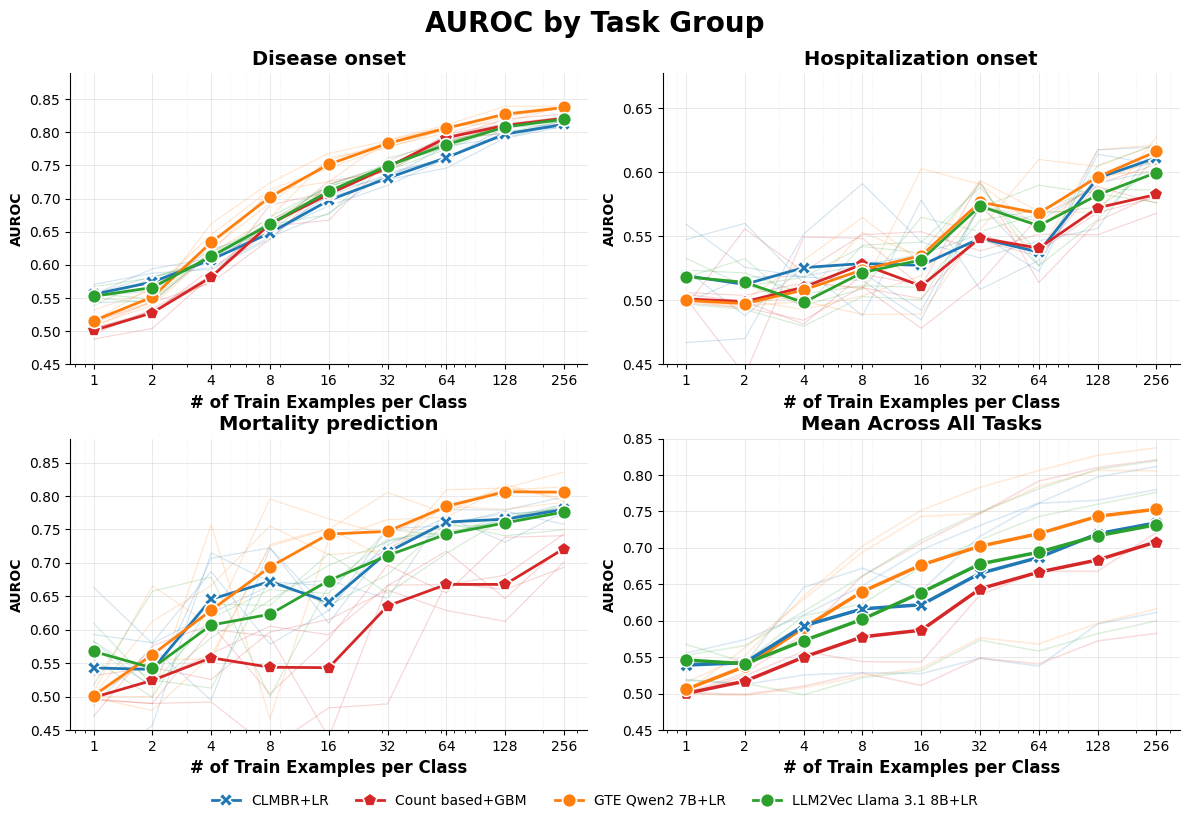

In [64]:
# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()  # Flatten to easily iterate through subplots
# Add a main title
plt.suptitle("AUROC by Task Group", fontsize=20, fontweight='bold', y=0.98)
# Keep track of legend information
legend_handles = []
legend_labels = []
# Add thin gridlines to all plots as in the reference image
for ax in axes:
    ax.grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)  # Horizontal lines
    ax.grid(True, axis='x', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)  # Vertical lines
    # Add minor grid lines (between labeled ticks) for better looks
    ax.grid(True, which='minor', axis='x', linestyle=':', alpha=0.2)
    #Remove top and right spines, keep only left and bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

# Use all_scores directly if model_name and task_mapping aren't dictionaries
# If they are dictionaries, you can uncomment the mapping lines
all_scores_renamed = all_scores.copy()  # Create a copy for renaming

# IMPORTANT: Check if model_name and task_mapping are dictionaries before using .map()
# If not, we'll skip these steps since we don't know their structure
all_scores_renamed["model"] = all_scores_renamed["model"].map(model_name)  # Rename models
all_scores_renamed["disease_group"] = all_scores_renamed["disease_group"].map(task_mapping)  # Rename tasks

# Store data for the mean plot
task_groups = sorted(all_scores_renamed["disease_group"].unique())
mean_plot_data = {task: [] for task in task_groups}
mean_plot_iterations = {task: {} for task in task_groups}

# Go through task groups and create plots for the first three subplots
for i, task in enumerate(task_groups):
    if i >= 3:  # Only create plots for first three (in case there are more than 3 groups)
        break
        
    pvt_table = all_scores_renamed[all_scores_renamed["disease_group"] == task]
    pvt_table = pvt_table.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({
                'auroc': 'mean',
            }).reset_index()
    
    # Get current axis
    ax = axes[i]
    
    # Add transparency lines for each iteration
    iterations = pvt_table['crossval_iteration'].unique()
    for model in pvt_table['model'].unique():
        model_data = pvt_table[pvt_table['model'] == model]
        for iter in iterations:
            iter_data = model_data[model_data['crossval_iteration'] == iter]
            iter_data = iter_data.sort_values('sample_size')
            ax.plot(
                iter_data['sample_size'], 
                iter_data['auroc'], 
                color=model_palette[model],
                alpha=0.2,
                linewidth=0.8
            )
            
            # Store iteration data for mean plot
            if model not in mean_plot_iterations[task]:
                mean_plot_iterations[task][model] = {}
            mean_plot_iterations[task][model][iter] = iter_data
    
    # Plot mean auroc line with markers
    for model in pvt_table['model'].unique():
        model_data = pvt_table[pvt_table['model'] == model]
        mean_data = model_data.groupby('sample_size')['auroc'].mean().reset_index()
        mean_data = mean_data.sort_values('sample_size')
        
        # Store mean data for mean plot
        mean_plot_data[task].append((model, mean_data))
        
        line = ax.plot(
            mean_data['sample_size'],
            mean_data['auroc'],
            color=model_palette[model],
            marker=model_markers[model],
            markersize=10,
            label=model,
            linewidth=2,
            markeredgewidth=1.2,
            markeredgecolor='white'
        )
        
        # Extract legend info from the first plot
        if i == 0:
            legend_handles.append(line[0])
            legend_labels.append(model)
    
    # Remove individual legend
    if ax.get_legend():
        ax.get_legend().remove()
    
    # Set x-axis to log scale
    ax.set_xscale("log")
    
    # Modify x-ticks to display integer values
    xticks = sorted(pvt_table["sample_size"].unique())
    if "All" in xticks:
        xticks.remove("All")
        xticks.append("All")
    ax.set_xticks(xticks[:-1] + [256])  # Remove "All" and add 256 for proper scaling
    ax.set_xticklabels([str(int(x)) if isinstance(x, (int, float)) else x for x in xticks])
    
    # Set title and labels
    ax.set_title(task, fontsize=14, fontweight='bold')
    ax.set_xlabel("# of Train Examples per Class", fontsize=12, fontweight='bold')
    ax.set_ylabel("AUROC", fontsize=10, fontweight='bold')
    
    # Set y-axis limits based on the data
    y_min = max(0.45, pvt_table['auroc'].min() - 0.05)
    y_max = min(1.0, pvt_table['auroc'].max() + 0.05)
    ax.set_ylim(y_min, y_max)

# Create the mean plot (fourth subplot)
ax = axes[3]

# First plot individual task lines (blurred background)
for task in task_groups:
    for model, mean_data in mean_plot_data[task]:
        ax.plot(
            mean_data['sample_size'],
            mean_data['auroc'],
            color=model_palette[model],
            alpha=0.15,  # More transparent for background
            linewidth=1.2,
            linestyle='-'
        )

# Get a unified list of models across all tasks
all_models = set()
for task in task_groups:
    for model_data in pvt_table['model'].unique():
        all_models.add(model_data)

# Calculate and plot the mean across all tasks
for model in all_models:
    # Collect sample sizes across all tasks
    all_sample_sizes = set()
    for task in task_groups:
        for selected_model, mean_data in mean_plot_data[task]:
            if selected_model == model:
                all_sample_sizes.update(mean_data['sample_size'].values)
    
    all_sample_sizes = sorted(all_sample_sizes)
    
    # Initialize arrays for accumulating values
    mean_aurocs = {size: [] for size in all_sample_sizes}
    
    # Collect values from each task
    for task in task_groups:
        for selected_model, mean_data in mean_plot_data[task]:
            if selected_model == model:
                for _, row in mean_data.iterrows():
                    if row['sample_size'] in mean_aurocs:
                        mean_aurocs[row['sample_size']].append(row['auroc'])
    
    # Calculate mean for each sample size
    sample_sizes = []
    aurocs = []
    for size in all_sample_sizes:
        if mean_aurocs[size]:  # Ensure we have values
            sample_sizes.append(size)
            aurocs.append(np.mean(mean_aurocs[size]))
    
    # Plot the mean line
    line = ax.plot(
        sample_sizes,
        aurocs,
        color=model_palette[model],
        marker=model_markers[model],
        markersize=10,
        label=model,
        linewidth=2.5,  # Slightly thicker line for emphasis
        markeredgewidth=1,
        markeredgecolor='white'
    )

# Remove individual legend
if ax.get_legend():
    ax.get_legend().remove()

# Set x-axis to log scale
ax.set_xscale("log")

# Modify x-ticks to display integer values (reuse from previous plots)
ax.set_xticks(xticks[:-1] + [256])
ax.set_xticklabels([str(int(x)) if isinstance(x, (int, float)) else x for x in xticks])

# Set title and labels
ax.set_title("Mean Across All Tasks", fontsize=14, fontweight='bold')
ax.set_xlabel("# of Train Examples per Class", fontsize=12, fontweight='bold')
ax.set_ylabel("AUROC", fontsize=10, fontweight='bold')

# Set y-axis with minimum of 0.45 as requested
ax.set_ylim(0.45, 0.85)

# Add gridlines consistent with other plots
ax.grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
ax.grid(True, axis='x', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
ax.grid(True, which='minor', axis='x', linestyle=':', alpha=0.2)

# Add a common legend at the bottom
plt.figlegend(
    legend_handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.08),
    ncol=min(len(legend_labels), 4),
    frameon=False
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.91, bottom=0.18)
plt.show()

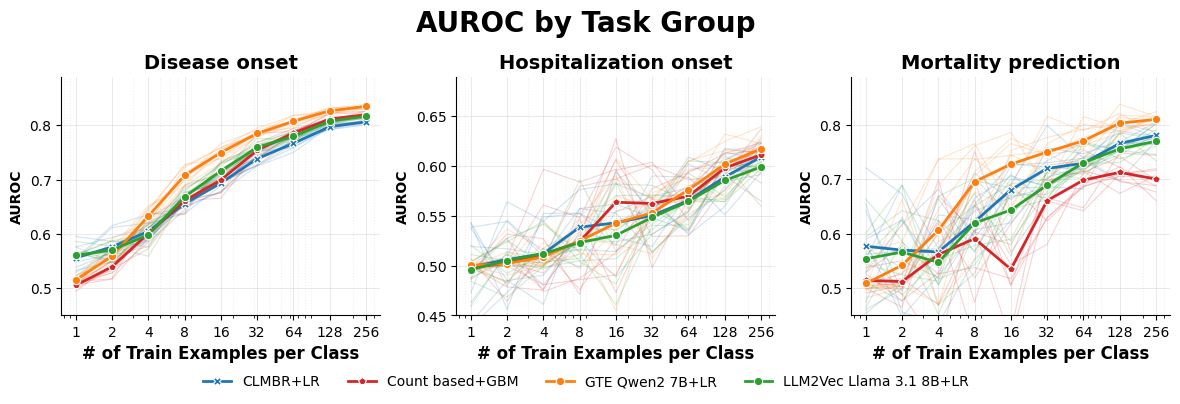

In [ ]:
# Create a 1x3 figure
fig, axes = plt.subplots(2, 2, figsize=(12, 4.5))
axes = axes.flatten()  # Flatten to easily iterate through subplots

# Add a main title
plt.suptitle("AUROC by Task Group", fontsize=20, fontweight='bold', y=0.98)

# Keep track of legend information
first_plot_done = False
legend_handles = []
legend_labels = []

# Add thin gridlines to all plots as in the reference image
for ax in axes:
    #ax.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
    ax.grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)  # Horizontal lines
    ax.grid(True, axis='x', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)  # Vertical lines

    # Add minor grid lines (between labeled ticks) for better looks
    ax.grid(True, which='minor', axis='x', linestyle=':', alpha=0.2)

    #Remove top and right spines, keep only left and bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

all_scores_renamed = all_scores.copy()  # Create a copy for renaming
all_scores_renamed["model"] = all_scores_renamed["model"].map(model_name)  # Rename models
all_scores_renamed["disease_group"] = all_scores_renamed["disease_group"].map(task_mapping)  # Rename tasks

# Go through task groups and create plots
for i, task in enumerate(sorted(all_scores_renamed["disease_group"].unique())):
    pvt_table = all_scores_renamed[all_scores_renamed["disease_group"] == task]
    pvt_table = pvt_table.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({
                    'auroc': 'mean',
                }).reset_index()
    # Get current axis
    ax = axes[i]
    
    # Add transparency lines for each iteration
    iterations = pvt_table['crossval_iteration'].unique()
    for model in pvt_table['model'].unique():
        model_data = pvt_table[pvt_table['model'] == model]
        for iter in iterations:
            iter_data = model_data[model_data['crossval_iteration'] == iter]
            iter_data = iter_data.sort_values('sample_size')
            ax.plot(
                iter_data['sample_size'], 
                iter_data['auroc'], 
                color=model_palette[model],
                alpha=0.2,
                linewidth=0.8
            )
    
    # Plot mean auroc line with markers
    for model in pvt_table['model'].unique():
        model_data = pvt_table[pvt_table['model'] == model]
        mean_data = model_data.groupby('sample_size')['auroc'].mean().reset_index()
        mean_data = mean_data.sort_values('sample_size')
        
        line = ax.plot(
            mean_data['sample_size'],
            mean_data['auroc'],
            color=model_palette[model],
            marker=model_markers[model],
            markersize=6,
            label=model,
            linewidth=2,
            markeredgewidth=0.8,
            markeredgecolor='white'
        )
        
        # Extract legend info from the first plot
        if i == 0:
            legend_handles.append(line[0])
            legend_labels.append(model)
    
    # Remove individual legend
    if ax.get_legend():
        ax.get_legend().remove()
    
    # Set x-axis to log scale
    ax.set_xscale("log")
    #ax.grid(True, which='minor', linestyle=':', alpha=0.2)
    
    
    # Modify x-ticks to display integer values
    xticks = sorted(pvt_table["sample_size"].unique())
    if "All" in xticks:
        xticks.remove("All")
        xticks.append("All")
    ax.set_xticks(xticks[:-1] + [256])  # Remove "All" and add 256 for proper scaling
    ax.set_xticklabels([str(int(x)) if isinstance(x, (int, float)) else x for x in xticks])
    
    # Set title and labels
    ax.set_title(task, fontsize=14, fontweight='bold')
    ax.set_xlabel("# of Train Examples per Class", fontsize=12, fontweight='bold')
    ax.set_ylabel("AUROC", fontsize=10, fontweight='bold')
    
    # Set y-axis limits based on the data
    y_min = max(0.45, pvt_table['auroc'].min() - 0.05)
    y_max = min(1.0, pvt_table['auroc'].max() + 0.05)
    ax.set_ylim(y_min, y_max)

# Add a common legend at the bottom
plt.figlegend(
    legend_handles,
    legend_labels,
    #title="Model",
    loc="lower center",
    bbox_to_anchor=(0.5, 0.11),
    ncol=min(len(legend_labels), 4),
    frameon=False
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.83, bottom=0.3)

plt.show()

/tmp/ipykernel_2676924/2466761257.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_scores["disease_group"] = all_scores["disease"].apply(


TypeError: 'str' object is not callable

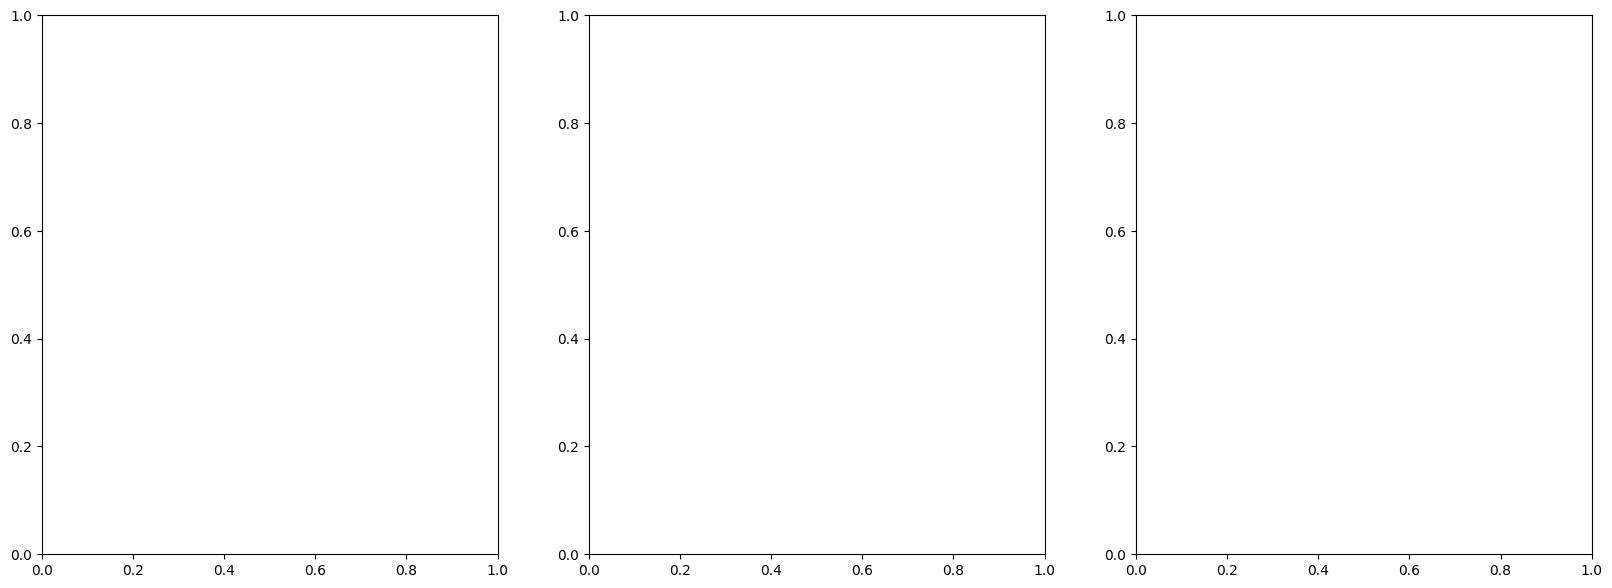

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single figure with 3 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # Make it a bit taller for legend space

# Store for collecting legend information
first_plot_done = False
legend_handles = []
legend_labels = []


all_scores["disease_group"] = all_scores["disease"].apply(
    lambda x: x if x in selected_diseases else "disease_onset"
)

# Go through disease_group and create plots
for i, task in enumerate(sorted(all_scores["disease_group"].unique())):
    pvt_table = all_scores[all_scores["disease_group"] == task]
    
    # Apply model name mapping
    pvt_table["model"] = pvt_table["model"].map(model_name)  # Rename models
    
    # Get current axis
    ax = axes[i]
    
    # Plot mean auroc with standard deviation as shaded region
    line_plot = sns.lineplot(
        data=pvt_table.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({
            'auroc': 'mean',
        }).reset_index(),
        x='sample_size',
        y='auroc',
        hue='model',
        marker="o",
        markersize=8,
        palette=model_palette,
        ax=ax
    )
    
    # Extract legend info from the first plot
    if i == 0:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    
    # Remove the individual legend
    ax.get_legend().remove()
    
    ax.set_xlabel("# of Train Examples per Class")
    ax.set_ylabel("AUROC")
    ax.set_xscale("log", base=2)  # Apply log-2 scaling to x-axis
    
    # Modify the x-ticks to display integer values instead of powers of 2
    xticks = sorted(pvt_table["sample_size"].unique())
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(x)) for x in xticks])  # Convert to integer labels
    
    ax.set_title(task)

# Add a common legend at the bottom of the figure - OUTSIDE the subplots
plt.figlegend(
    legend_handles, 
    legend_labels, 
    title="Model", 
    loc="lower center", 
    bbox_to_anchor=(0.5, 0.0), 
    ncol=min(len(legend_labels), 4)
)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add space at bottom for legend

# Save and show the plot
#plt.savefig('combined_disease_plots.png', bbox_inches='tight', dpi=300)
plt.show()

In [34]:
disease_mapping = {
    "admin_hospital": ("Hospitalization", 10000),
    "admin_death": ("Death", 291),
    "phecode_CV_401": ("Hypertension", 10000),
    "phecode_EM_202": ("Diabetes mellitus", 3841),
    "phecode_RE_468": ("Pneumonia", 298),
    "phecode_RE_474": ("Chronic obstructive pulmonary disease [COPD]", 935),
    "phecode_GU_582.2": ("Chronic kidney disease", 166),
    "phecode_CV_404": ("Ischemic heart disease", 4520),
    "phecode_CV_404.1": ("Myocardial infarction [Heart attack]", 480),
    "phecode_CV_431.11": ("Cerebral infarction [Ischemic stroke]", 134),
    "phecode_CV_424": ("Heart failure", 338),
    "phecode_CV_420": ("Cardiac arrest", 19),
    "phecode_CV_438.11": ("Abdominal aortic aneurysm", 24),
    "phecode_CV_440.3": ("Pulmonary embolism", 137),
    "phecode_CV_413.21": ("Aortic stenosis", 22),
    "phecode_CV_413.11": ("Mitral valve insufficiency", 59),
    "phecode_CV_410.2": ("Endocarditis", 17),
    "phecode_CV_400": ("Rheumatic fever and chronic rheumatic heart diseases", 49),
    "phecode_BI_164": ("Anemia", 1500),
    "phecode_MS_718": ("Back pain", 412),
    "phecode_NS_324.11": ("Parkinson's disease (Primary)", 45),
    "phecode_MS_705.1": ("Rheumatoid arthritis", 290),
    "phecode_DE_664.4": ("Psoriasis", 45),
    "phecode_MB_284": ("Suicide ideation and attempt or self harm", 32),
}

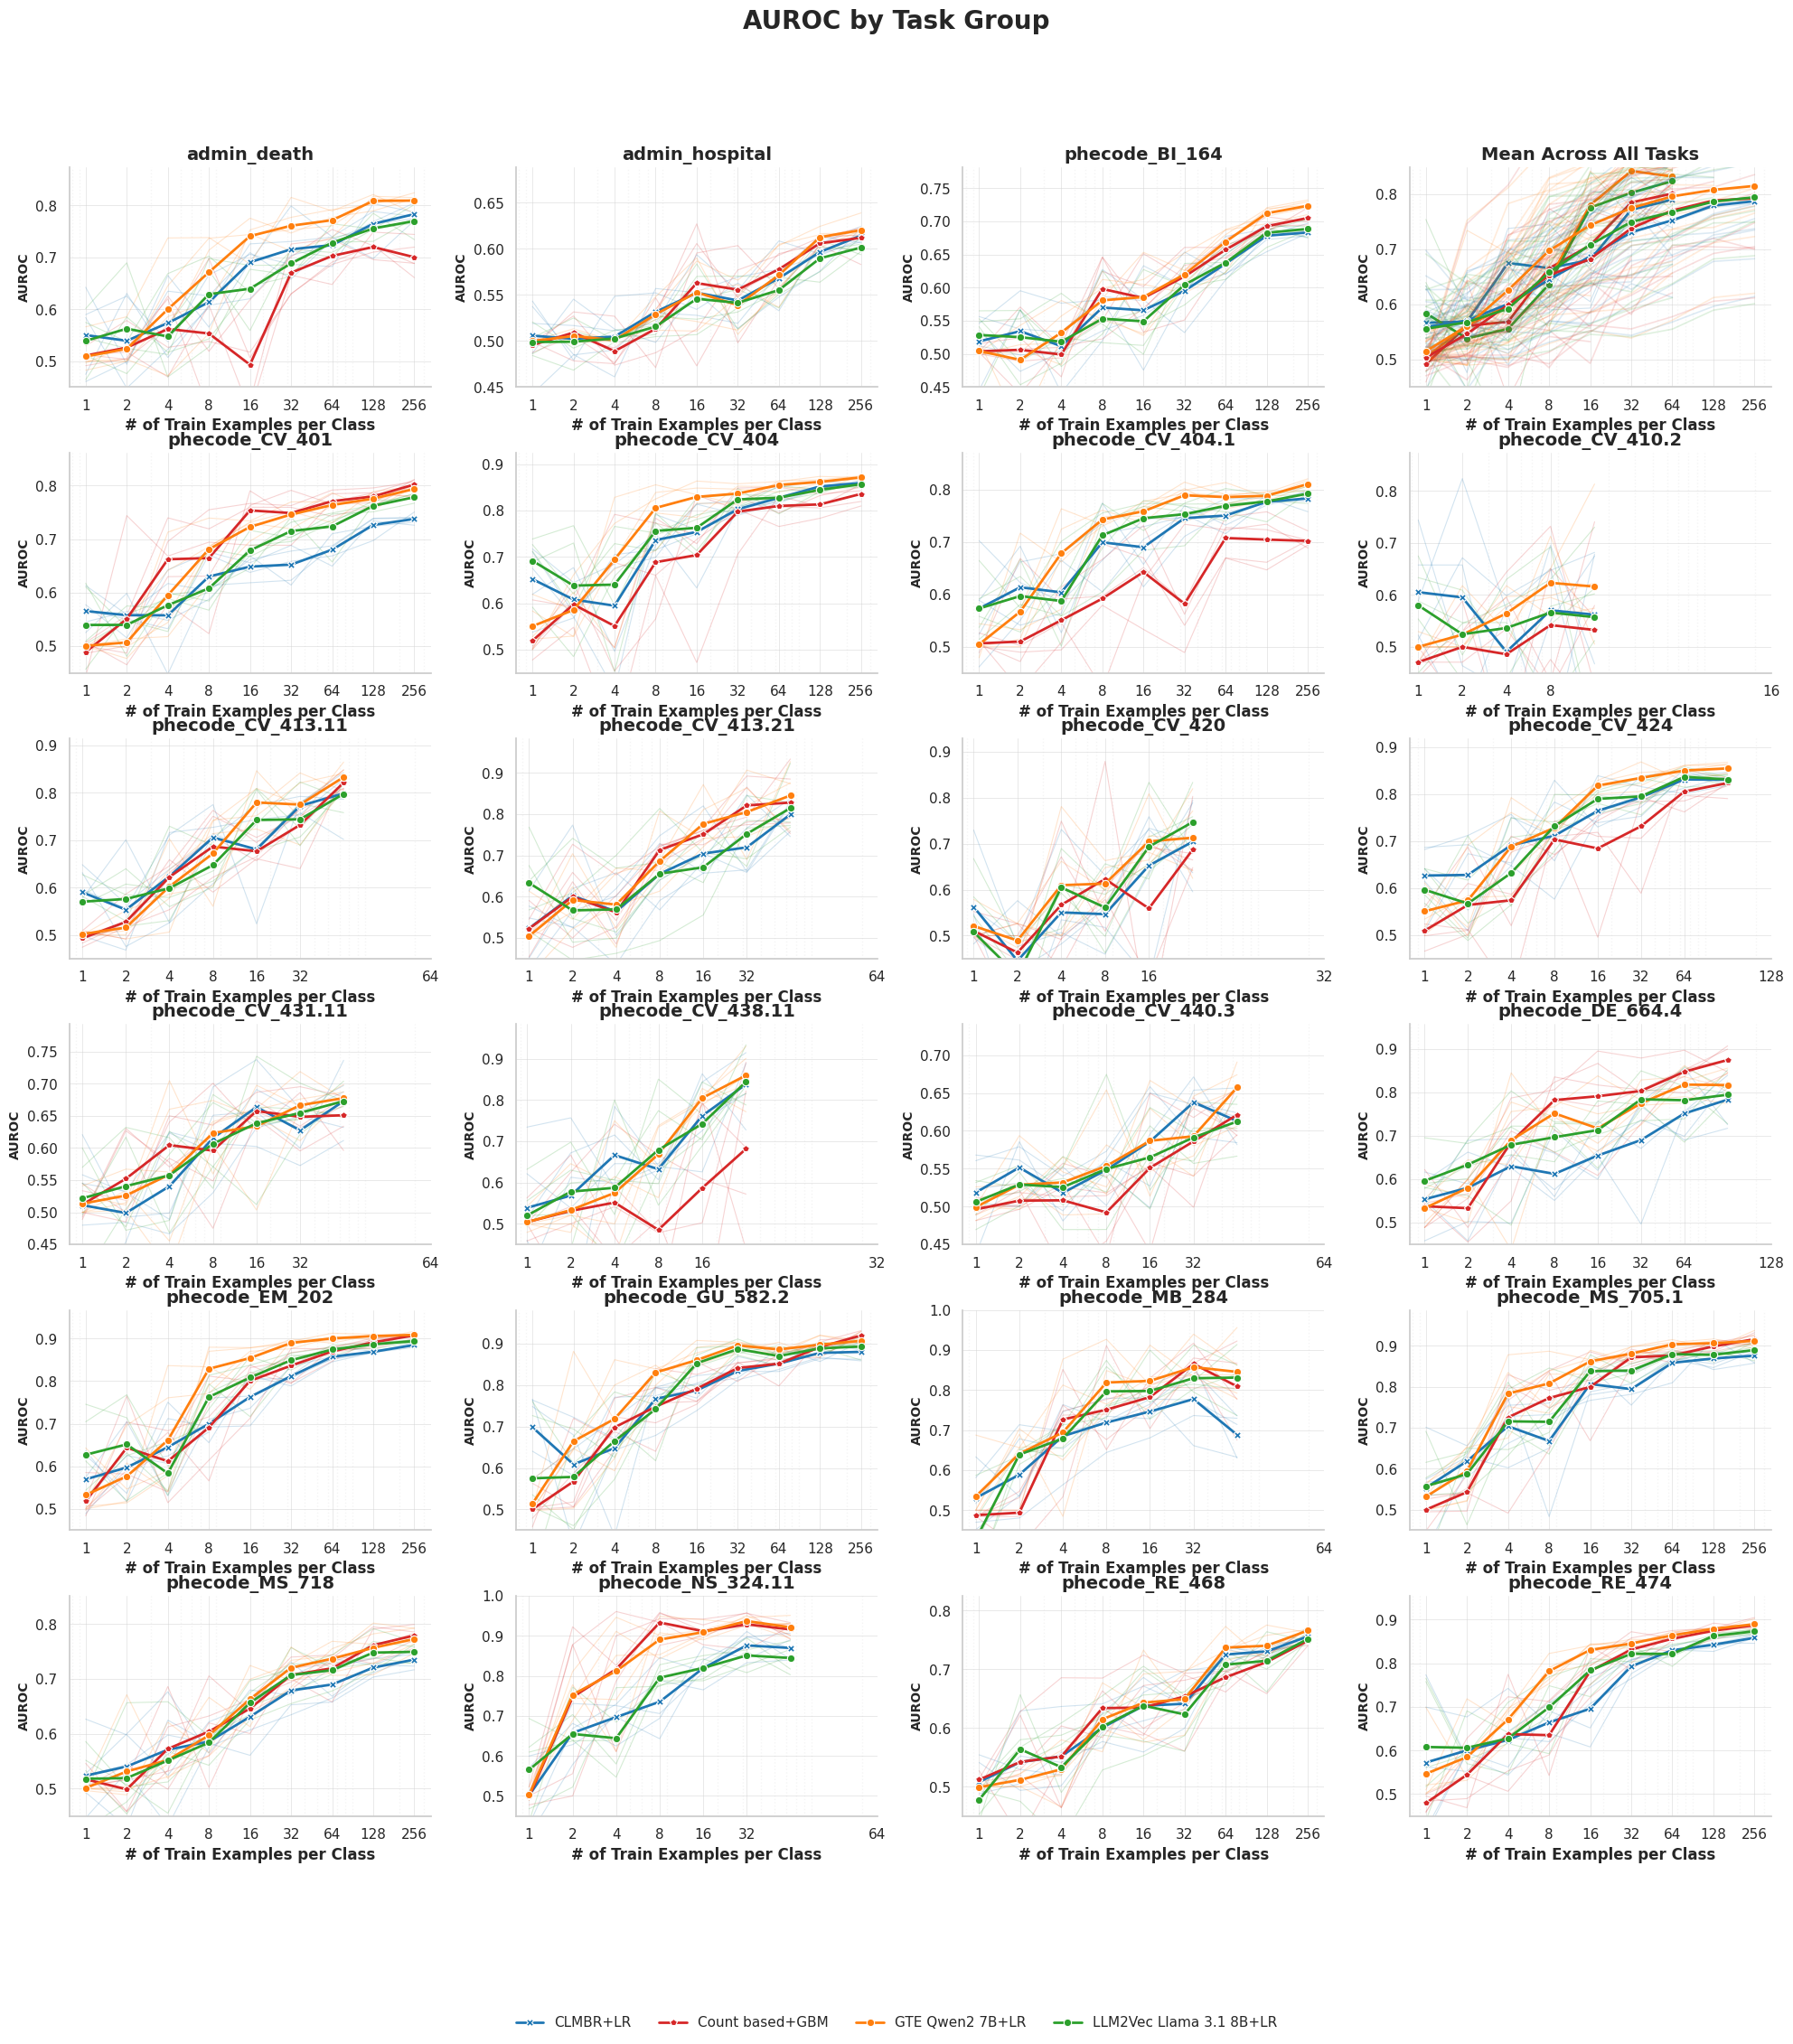

In [40]:
# Create a 2x2 figure (four plots total)
fig, axes = plt.subplots(6, 4, figsize=(20, 25))  # Increased height slightly
axes = axes.flatten()  # Flatten to easily iterate through subplots

# Add a main title
plt.suptitle("AUROC by Task Group", fontsize=20, fontweight='bold', y=0.98)

# Keep track of legend information
legend_handles = []
legend_labels = []

# Add thin gridlines to all plots
for ax in axes:
    ax.grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
    ax.grid(True, axis='x', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
    ax.grid(True, which='minor', axis='x', linestyle=':', alpha=0.2)
    
    # Remove top and right spines, keep only left and bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

all_scores_renamed = all_scores.copy()  # Create a copy for renaming
all_scores_renamed["model"] = all_scores_renamed["model"].map(model_name)  # Rename models
all_scores_renamed["disease_group"] = all_scores_renamed["disease_group"].map(task_mapping)  # Rename tasks

# Go through task groups and create plots for the first three plots
task_groups = sorted(all_scores_renamed["disease"].unique())
for i, task in enumerate(task_groups):
    pvt_table = all_scores_renamed[all_scores_renamed["disease"] == task]
    pvt_table = pvt_table.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({
                    'auroc': 'mean',
                }).reset_index()
    # Get current axis
    ax = axes[i]
    
    # Add transparency lines for each iteration
    iterations = pvt_table['crossval_iteration'].unique()
    for model in pvt_table['model'].unique():
        model_data = pvt_table[pvt_table['model'] == model]
        for iter in iterations:
            iter_data = model_data[model_data['crossval_iteration'] == iter]
            iter_data = iter_data.sort_values('sample_size')
            ax.plot(
                iter_data['sample_size'], 
                iter_data['auroc'], 
                color=model_palette[model],
                alpha=0.2,
                linewidth=0.8
            )
    
    # Plot mean auroc line with markers
    for model in pvt_table['model'].unique():
        model_data = pvt_table[pvt_table['model'] == model]
        mean_data = model_data.groupby('sample_size')['auroc'].mean().reset_index()
        mean_data = mean_data.sort_values('sample_size')
        
        line = ax.plot(
            mean_data['sample_size'],
            mean_data['auroc'],
            color=model_palette[model],
            marker=model_markers[model],
            markersize=6,
            label=model,
            linewidth=2,
            markeredgewidth=0.8,
            markeredgecolor='white'
        )
        
        # Extract legend info from the first plot
        if i == 0:
            legend_handles.append(line[0])
            legend_labels.append(model)
    
    # Remove individual legend
    if ax.get_legend():
        ax.get_legend().remove()
    
    # Set x-axis to log scale
    ax.set_xscale("log")
    
    # Modify x-ticks to display integer values
    xticks = sorted(pvt_table["sample_size"].unique())
    if "All" in xticks:
        xticks.remove("All")
        xticks.append("All")
    ax.set_xticks(xticks[:-1] + [256])  # Remove "All" and add 256 for proper scaling
    ax.set_xticklabels([str(int(x)) if isinstance(x, (int, float)) else x for x in xticks])
    
    # Set title and labels
    ax.set_title(task, fontsize=14, fontweight='bold')
    ax.set_xlabel("# of Train Examples per Class", fontsize=12, fontweight='bold')
    ax.set_ylabel("AUROC", fontsize=10, fontweight='bold')
    
    # Set y-axis limits based on the data
    y_min = max(0.45, pvt_table['auroc'].min() - 0.05)
    y_max = min(1.0, pvt_table['auroc'].max() + 0.05)
    ax.set_ylim(y_min, y_max)

# Now create the fourth plot with the mean across all disease groups
ax = axes[3]  # Fourth subplot

# First, plot the mean performance for each disease group as blurred lines
for task in task_groups:
    # Get data for this task
    task_table = all_scores_renamed[all_scores_renamed["disease"] == task]
    task_means = task_table.groupby(['sample_size', 'model'])[['auroc']].mean().reset_index()
    
    # Plot mean line for each model for this task group
    for model in task_means['model'].unique():
        model_data = task_means[task_means['model'] == model]
        model_data = model_data.sort_values('sample_size')
        
        # Plot with higher transparency
        ax.plot(
            model_data['sample_size'],
            model_data['auroc'],
            color=model_palette[model],
            alpha=0.15,  # Very transparent to show as background
            linewidth=1.2,
            linestyle='-'
        )

# Then calculate and plot the overall mean across all disease groups
mean_table = all_scores_renamed.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({
                'auroc': 'mean',
            }).reset_index()

# Plot mean auroc line with markers (the main focus)
for model in mean_table['model'].unique():
    model_data = mean_table[mean_table['model'] == model]
    mean_data = model_data.groupby('sample_size')['auroc'].mean().reset_index()
    mean_data = mean_data.sort_values('sample_size')
    
    ax.plot(
        mean_data['sample_size'],
        mean_data['auroc'],
        color=model_palette[model],
        marker=model_markers[model],
        markersize=6,
        label=model,
        linewidth=2,
        markeredgewidth=0.8,
        markeredgecolor='white'
    )

# Remove individual legend
if ax.get_legend():
    ax.get_legend().remove()

# Set x-axis to log scale
ax.set_xscale("log")
ax.grid(True, which='minor', axis='x', linestyle=':', alpha=0.2)

# Modify x-ticks to display integer values
xticks = sorted(mean_table["sample_size"].unique())
if "All" in xticks:
    xticks.remove("All")
    xticks.append("All")
ax.set_xticks(xticks[:-1] + [256])  # Remove "All" and add 256 for proper scaling
ax.set_xticklabels([str(int(x)) if isinstance(x, (int, float)) else x for x in xticks])

# Set title and labels
ax.set_title("Mean Across All Tasks", fontsize=14, fontweight='bold')
ax.set_xlabel("# of Train Examples per Class", fontsize=12, fontweight='bold')
ax.set_ylabel("AUROC", fontsize=10, fontweight='bold')

# Set y-axis limits based on the data
y_min = max(0.45, all_scores_renamed['auroc'].min() - 0.05)
y_max = min(0.85, all_scores_renamed['auroc'].max() + 0.05)
ax.set_ylim(y_min, y_max)

# Add a common legend at the bottom
plt.figlegend(
    legend_handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.08),
    ncol=min(len(legend_labels), 4),
    frameon=False
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.91, bottom=0.18)

plt.show()

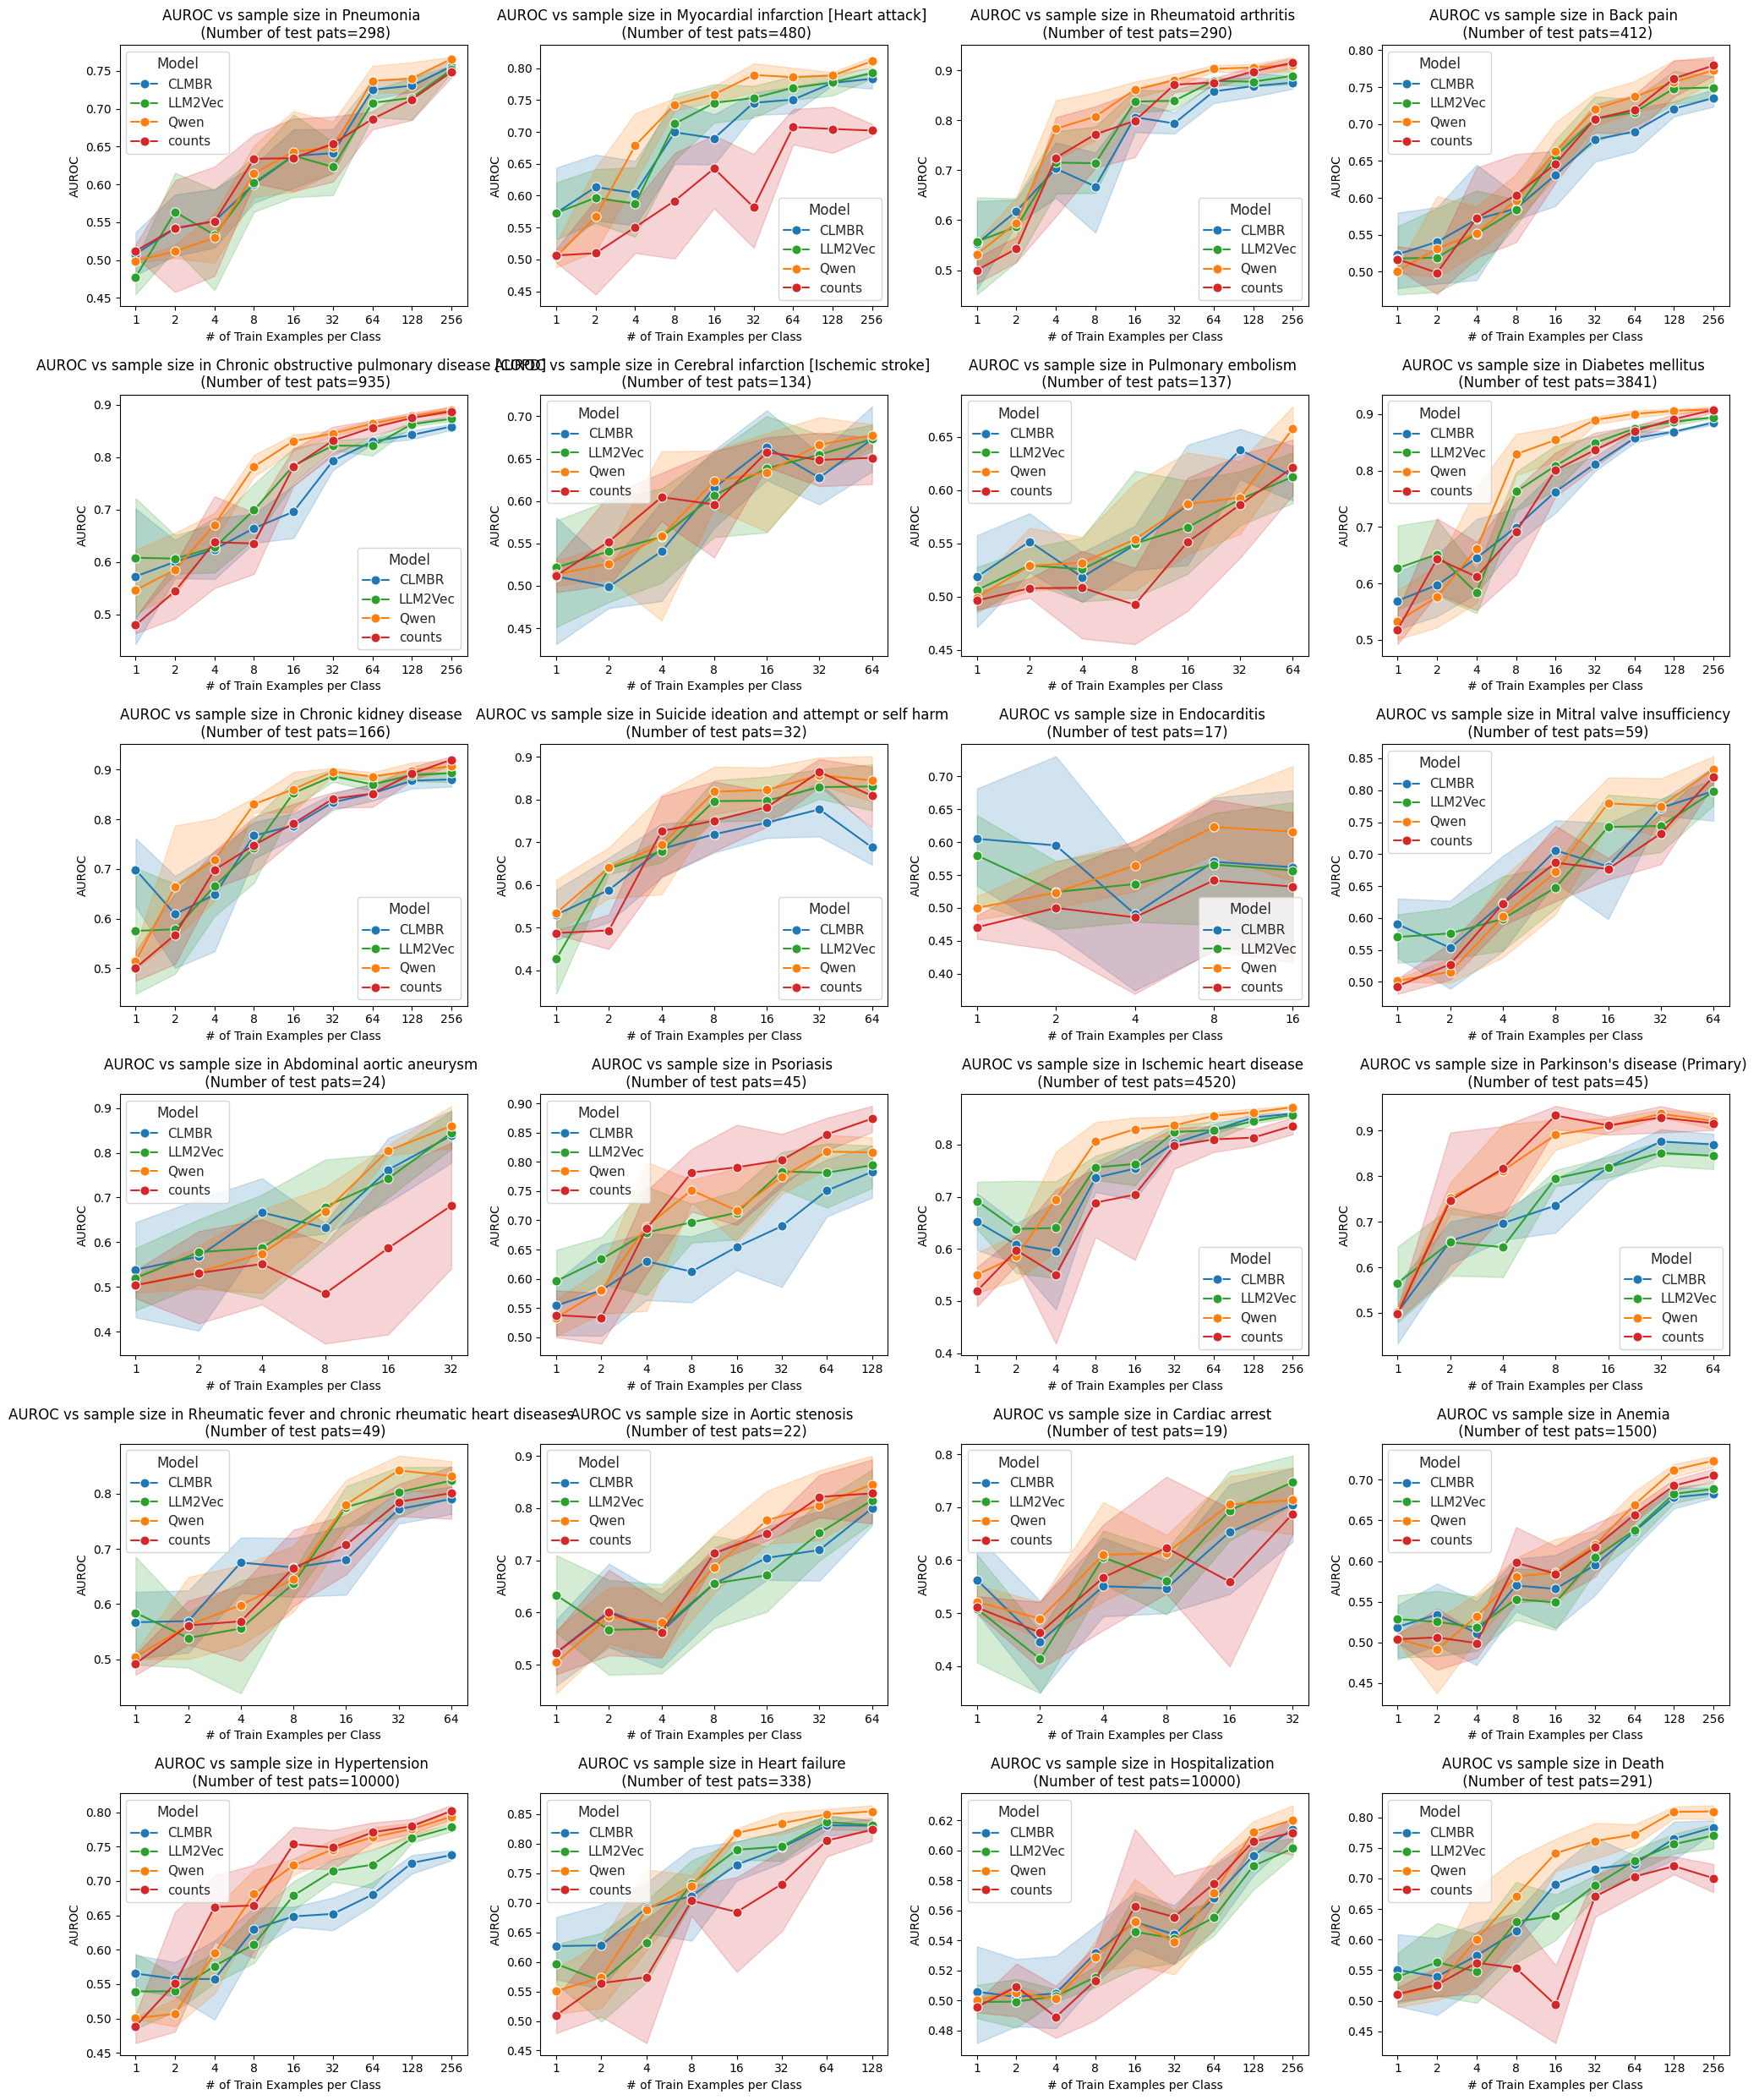

In [35]:
model_palette = {
    "LLM2Vec": "#2ca02c",   # green
    "Qwen": "#ff7f0e",           # orange
    "CLMBR": "#1f77b4",                  # blue
    "counts": "#d62728",          # red
}

# Create figure and subplots
fig, axes = plt.subplots(6, 4, figsize=(20, 25))
axes = axes.flatten()

# Loop through diseases and plot
for i, disease in enumerate(all_scores["disease"].unique()):
    if disease not in disease_mapping:
        continue  # Skip if not in mapping
    
    full_name, test_count = disease_mapping[disease]
    pvt_table = all_scores[all_scores["disease"] == disease]

    sns.set(style="whitegrid")
    ax = axes[i]

    sns.lineplot(
        data=pvt_table.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({'auroc': 'mean'}).reset_index(),
        x='sample_size',
        y='auroc',
        hue='model',
        marker="o",
        markersize=8,
        ax=ax,
        palette=model_palette,
    )

    ax.set_xscale('log', base=2)
    ax.set_xlabel("# of Train Examples per Class")
    ax.set_ylabel("AUROC")
    ax.set_title(f"AUROC vs sample size in {full_name} \n (Number of test pats={test_count})")  # Updated title
    ax.legend(title="Model")

    xticks = sorted(pvt_table["sample_size"].unique())
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(x)) for x in xticks])  # Ensure tick labels are integers

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [ ]:
# Find global min and max sample size
min_x = all_scores["sample_size"].min()
max_x = all_scores["sample_size"].max()

# Create figure and subplots
fig, axes = plt.subplots(6, 4, figsize=(20, 25))
axes = axes.flatten()

# Loop through diseases and plot
for i, disease in enumerate(all_scores["disease"].unique()):
    if disease not in disease_mapping:
        continue  # Skip if not in mapping
    
    full_name, test_count = disease_mapping[disease]
    pvt_table = all_scores[all_scores["disease"] == disease]

    sns.set(style="whitegrid")
    ax = axes[i]

    sns.lineplot(
        data=pvt_table.groupby(['sample_size', 'crossval_iteration', 'model'])[['auroc']].agg({'auroc': 'mean'}).reset_index(),
        x='sample_size',
        y='auroc',
        hue='model',
        marker="o",
        markersize=8,
        ax=ax
    )

    ax.set_xscale('log', base=2)
    ax.set_xlim(min_x, max_x)  # **Set same x-axis limits for all subplots**
    ax.set_xlabel("Sample Size (log2 scale)")
    ax.set_ylabel("Mean AUROC")
    ax.set_title(f"{full_name} (N={test_count})")  # Updated title
    ax.legend(title="Model")
    ax.set_xticks(sorted(pvt_table["sample_size"].unique()))

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [ ]:
all_scores.pivot_table(
    index=['disease'], 
    values='auroc', 
    columns=['model', 'case', 'balanced'], 
    aggfunc=['mean', 'std']
)

mean                                              \
model                  CLMBR    LLM2Vec    NVEmbed       Qwen     counts   
case                     0-1        0-1        0-1        0-1        0-1   
balanced          _balanced_ _balanced_ _balanced_ _balanced_ _balanced_   
disease                                                                    
admin_death         0.580850   0.660961   0.655490   0.664961   0.610182   
admin_hospital      0.513816   0.547725   0.536252   0.541469   0.551548   
phecode_BI_164      0.516537   0.548026   0.537828   0.534473   0.540858   
phecode_CV_400      0.532208   0.597739   0.653483   0.650304   0.586621   
phecode_CV_401      0.523146   0.549496   0.569276   0.572571   0.545113   
phecode_CV_404      0.561310   0.601177   0.623489   0.628384   0.535787   
phecode_CV_404.1    0.578325   0.620984   0.656325   0.658687   0.523160   
phecode_CV_410.2    0.539314   0.602785   0.594033   0.594774   0.548738   
phecode_CV_413.11   0.569887   0.621799   0.606850   0.609727   0.580449   
phecode_CV_413.21   0.529524   0.571213   0.627111   0.622759   0.575696   
phecode_CV_420      0.580510   0.616047   0.632782   0.629477   0.570730   
phecode_CV_424      0.578897   0.664849   0.675642   0.675203   0.601486   
phecode_CV_431.11   0.522227   0.603786   0.629001   0.625448   0.576748   
phecode_CV_438.11   0.579835   0.637686   0.762562   0.759504   0.520661   
phecode_CV_440.3    0.533778   0.542779   0.560452   0.558720   0.535803   
phecode_DE_664.4    0.563049   0.601626   0.582275   0.570434   0.577113   
phecode_EM_202      0.524410   0.565327   0.569165   0.569323   0.526639   
phecode_GU_582.2    0.625045   0.724489   0.697576   0.684465   0.680054   
phecode_MB_284      0.591156   0.669652   0.648959   0.627416   0.627096   
phecode_MS_705.1    0.517651   0.542395   0.537823   0.546670   0.526299   
phecode_MS_718      0.672089   0.757598   0.695749   0.663573   0.701979   
phecode_RE_468      0.542087   0.593672   0.594828   0.598183   0.569018   
phecode_RE_474      0.552326   0.622673   0.623534   0.637024   0.604543   

                         std                                              
model                  CLMBR    LLM2Vec    NVEmbed       Qwen     counts  
case                     0-1        0-1        0-1        0-1        0-1  
balanced          _balanced_ _balanced_ _balanced_ _balanced_ _balanced_  
disease                                                                   
admin_death         0.072465   0.096500   0.120270   0.128434   0.099534  
admin_hospital      0.015950   0.039547   0.039557   0.043008   0.044282  
phecode_BI_164      0.031811   0.061869   0.046462   0.044779   0.044036  
phecode_CV_400      0.064358   0.090081   0.079603   0.086410   0.103375  
phecode_CV_401      0.027393   0.048622   0.072768   0.070746   0.043123  
phecode_CV_404      0.053920   0.079648   0.094479   0.088936   0.053209  
phecode_CV_404.1    0.075437   0.083054   0.090726   0.088904   0.071582  
phecode_CV_410.2    0.078492   0.112020   0.105738   0.097126   0.081156  
phecode_CV_413.11   0.081551   0.099178   0.089859   0.098147   0.090632  
phecode_CV_413.21   0.082018   0.094812   0.118253   0.120777   0.115087  
phecode_CV_420      0.143539   0.150650   0.135725   0.118186   0.118447  
phecode_CV_424      0.067114   0.094372   0.105560   0.122229   0.091595  
phecode_CV_431.11   0.042063   0.074518   0.080286   0.089084   0.076710  
phecode_CV_438.11   0.107812   0.148520   0.126078   0.132904   0.148310  
phecode_CV_440.3    0.056989   0.067406   0.071135   0.073760   0.058205  
phecode_DE_664.4    0.070783   0.107970   0.069103   0.063755   0.060737  
phecode_EM_202      0.040572   0.054940   0.063519   0.066052   0.057644  
phecode_GU_582.2    0.088022   0.105729   0.122632   0.110109   0.113397  
phecode_MB_284      0.085716   0.112972   0.123944   0.124598   0.121201  
phecode_MS_705.1    0.045982   0.064161   0.065911   0.067572   0.047028  
phecode_MS_718      

In [6]:
all_scores_128 = all_scores[all_scores['sample_size'] == 128]

In [ ]:
pivot = all_scores_128.pivot_table(
    index=['disease'], 
    values='auroc', 
    columns=['model', 'case', 'balanced'],
    aggfunc=['mean', 'std']
)
filtered_pivot = pivot.loc[:, pivot.columns.get_level_values('balanced') == '_balanced_']
filtered_pivot

NameError: name 'all_scores_128' is not defined

In [8]:
### Add std deviation to the mean
# Fix for multi-index columns: Access mean and std properly
mean_df = filtered_pivot['mean'].round(4)
std_df = filtered_pivot['std'].round(4)

# Combine mean and std into a single formatted string
formatted_df = mean_df.astype(str) + " ± " + std_df.astype(str)

# Flatten column names
formatted_df.columns = ['_'.join(map(str, col)) for col in formatted_df.columns]
formatted_df.reset_index(inplace=True)

# Display result
formatted_df

disease CLMBR_0-1__balanced_ LLM2Vec_0-1__balanced_  \
0       admin_death      0.6145 ± 0.0377        0.6984 ± 0.0369   
1    phecode_BI_164      0.5044 ± 0.0147        0.5275 ± 0.0281   
2    phecode_CV_401       0.538 ± 0.0282         0.544 ± 0.0166   
3    phecode_CV_404      0.5904 ± 0.0308        0.6254 ± 0.0287   
4  phecode_CV_404.1      0.6425 ± 0.0609        0.6399 ± 0.0583   
5    phecode_EM_202      0.5324 ± 0.0273         0.5802 ± 0.029   
6    phecode_MS_718      0.6624 ± 0.0254        0.7671 ± 0.0167   
7    phecode_RE_468      0.5407 ± 0.0227        0.5951 ± 0.0211   
8    phecode_RE_474      0.6013 ± 0.0522        0.6375 ± 0.0616   

  NVEmbed_0-1__balanced_ Qwen_0-1__balanced_ counts_0-1__balanced_  
0        0.7076 ± 0.0268      0.707 ± 0.0515       0.7647 ± 0.0286  
1         0.537 ± 0.0193     0.5457 ± 0.0155        0.596 ± 0.0162  
2        0.5419 ± 0.0297     0.5426 ± 0.0188       0.5912 ± 0.0163  
3        0.6159 ± 0.0365     0.6098 ± 0.0288       0.6745 ± 0.0186  
4        0.6473 ± 0.0592     0.6512 ± 0.0388        0.7274 ± 0.057  
5        0.5739 ± 0.0255     0.5785 ± 0.0363         0.617 ± 0.026  
6        0.7522 ± 0.0182      0.7069 ± 0.038       0.8089 ± 0.0088  
7        0.6116 ± 0.0287     0.5884 ± 0.0432       0.6642 ± 0.0245  
8         0.629 ± 0.0555     0.6491 ± 0.0405       0.7338 ± 0.0271

In [ ]:
auroc_table = all_scores.pivot_table(index=['sample_size', 'model', 'case', 'balanced'], values='auroc', columns=['disease'], aggfunc=['mean', 'std'])
auroc_table

mean                                \
disease                             admin_death admin_hospital phecode_BI_164   
sample_size model   case balanced                                               
1           CLMBR   0-1  _balanced_    0.528501       0.502656       0.514706   
            LLM2Vec 0-1  _balanced_    0.545598       0.520755       0.502996   
            NVEmbed 0-1  _balanced_    0.541714       0.511311       0.502156   
            Qwen    0-1  _balanced_    0.540238       0.499364       0.500354   
            counts  0-1  _balanced_    0.502800       0.499963       0.498336   
2           CLMBR   0-1  _balanced_    0.518082       0.501049       0.495614   
            LLM2Vec 0-1  _balanced_    0.567518       0.515972       0.488347   
            NVEmbed 0-1  _balanced_    0.511780       0.497425       0.483527   
            Qwen    0-1  _balanced_    0.500963       0.498946       0.481888   
            counts  0-1  _balanced_    0.513186       0.507766       0.500666   
4           CLMBR   0-1  _balanced_    0.512309       0.511505       0.503764   
            LLM2Vec 0-1  _balanced_    0.561311       0.528852       0.524984   
            NVEmbed 0-1  _balanced_    0.547901       0.518436       0.514459   
            Qwen    0-1  _balanced_    0.546112       0.514493       0.509405   
            counts  0-1  _balanced_    0.511895       0.536190       0.520551   
8           CLMBR   0-1  _balanced_    0.553830       0.510349       0.516003   
            LLM2Vec 0-1  _balanced_    0.644830       0.524332       0.537365   
            NVEmbed 0-1  _balanced_    0.664677       0.515677       0.526617   
            Qwen    0-1  _balanced_    0.680442       0.530001       0.516220   
            counts  0-1  _balanced_    0.597590       0.531355       0.515158   
16          CLMBR   0-1  _balanced_    0.553966       0.510987       0.504075   
            LLM2Vec 0-1  _balanced_    0.638571       0.533582       0.529478   
            NVEmbed 0-1  _balanced_    0.672391       0.535931       0.519378   
            Qwen    0-1  _balanced_    0.689944       0.537458       0.529361   
            counts  0-1  _balanced_    0.621185       0.549289       0.539078   
32          CLMBR   0-1  _balanced_    0.582972       0.514443       0.519914   
            LLM2Vec 0-1  _balanced_    0.711674       0.552378       0.577431   
            NVEmbed 0-1  _balanced_    0.697498       0.530241       0.558037   
            Qwen    0-1  _balanced_    0.713605       0.543675       0.540977   
            counts  0-1  _balanced_    0.642712       0.564116       0.561053   
64          CLMBR   0-1  _balanced_    0.622898       0.519865       0.531202   
            LLM2Vec 0-1  _balanced_    0.734365       0.564708       0.584438   
            NVEmbed 0-1  _balanced_    0.722491       0.560459       0.569166   
            Qwen    0-1  _balanced_    0.750661       0.572985       0.567296   
            counts  0-1  _balanced_    0.667522       0.577309       0.571983   
128         CLMBR   0-1  _balanced_    0.665070       0.523713       0.524701   
            LLM2Vec 0-1  _balanced_    0.765726       0.582000       0.583839   
            NVEmbed 0-1  _balanced_    0.761576       0.564527       0.563392   
            Qwen    0-1  _balanced_    0.783238       0.578300       0.561966   
            counts  0-1  _balanced_    0.706317       0.591639       0.575480   
256         CLMBR   0-1  _balanced_    0.690020       0.529778       0.538854   
            LLM2Vec 0-1  _balanced_    0.779058       0.606950       0.603355   
            NVEmbed 0-1  _balanced_    0.779381       0.592260       0.603718   
            Qwen    0-1  _balanced_    0.779450       0.598000       0.602788   
            counts  0-1  _balanced_    0.728432       0.606308       0.585419   

                                                                   \
disease                             phecode_CV_400 phecode_CV_401   
sample_size mode

In [ ]:
auroc_table.query(f"model == 'LLM2Vec' and case==@case")

mean                                \
disease                             admin_death admin_hospital phecode_BI_164   
sample_size model   case balanced                                               
1           LLM2Vec 0-1  _balanced_    0.558484       0.526589       0.505704   
2           LLM2Vec 0-1  _balanced_    0.555034       0.515569       0.503798   
4           LLM2Vec 0-1  _balanced_    0.612989       0.515436       0.514359   
8           LLM2Vec 0-1  _balanced_    0.633833       0.527368       0.559337   
16          LLM2Vec 0-1  _balanced_    0.676313       0.534872       0.543321   
32          LLM2Vec 0-1  _balanced_    0.728688       0.538753       0.560384   
64          LLM2Vec 0-1  _balanced_    0.753656       0.553256       0.564319   
128         LLM2Vec 0-1  _balanced_    0.756144       0.586843       0.582380   
256         LLM2Vec 0-1  _balanced_    0.767152       0.597125       0.596185   

                                                                   \
disease                             phecode_CV_400 phecode_CV_401   
sample_size model   case balanced                                   
1           LLM2Vec 0-1  _balanced_       0.561892       0.511642   
2           LLM2Vec 0-1  _balanced_       0.524197       0.501084   
4           LLM2Vec 0-1  _balanced_       0.551128       0.526943   
8           LLM2Vec 0-1  _balanced_       0.592253       0.524610   
16          LLM2Vec 0-1  _balanced_       0.650087       0.551820   
32          LLM2Vec 0-1  _balanced_       0.693056       0.567700   
64          LLM2Vec 0-1  _balanced_            NaN       0.581878   
128         LLM2Vec 0-1  _balanced_            NaN       0.593525   
256         LLM2Vec 0-1  _balanced_            NaN       0.602450   

                                                                     \
disease                             phecode_CV_404 phecode_CV_404.1   
sample_size model   case balanced                                     
1           LLM2Vec 0-1  _balanced_       0.505051         0.515210   
2           LLM2Vec 0-1  _balanced_       0.522772         0.542908   
4           LLM2Vec 0-1  _balanced_       0.555291         0.567981   
8           LLM2Vec 0-1  _balanced_       0.580270         0.606396   
16          LLM2Vec 0-1  _balanced_       0.615937         0.607568   
32          LLM2Vec 0-1  _balanced_       0.619823         0.643604   
64          LLM2Vec 0-1  _balanced_       0.651094         0.701270   
128         LLM2Vec 0-1  _balanced_       0.674855         0.699634   
256         LLM2Vec 0-1  _balanced_       0.696968              NaN   

                                                                      \
disease                             phecode_CV_413.11 phecode_CV_420   
sample_size model   case balanced                                      
1           LLM2Vec 0-1  _balanced_          0.525208       0.555372   
2           LLM2Vec 0-1  _balanced_          0.524042       0.513223   
4           LLM2Vec 0-1  _balanced_          0.585764       0.604132   
8           LLM2Vec 0-1  _balanced_          0.624250       0.600000   
16          LLM2Vec 0-1  _balanced_          0.652917       0.673140   
32          LLM2Vec 0-1  _balanced_          0.725250       0.675207   
64          LLM2Vec 0-1  _balanced_               NaN            NaN   
128         LLM2Vec 0-1  _balanced_               NaN            NaN   
256         LLM2Vec 0-1  _balanced_               NaN            NaN   

                                                                      \
disease                             phecode_CV_424 phecode_CV_431.11   
sample_size model   case balanced                                      
1           LLM2Vec 0-1  _balanced_       0.556626          0.570949   
2           LLM2Vec 0-1  _balanced_       0.603064          0.503132   
4           LLM2Vec 0-1  _balanced_       0.617800          0.535305   
8           LLM2Vec 0-1  _balanced_       0.629599          0.564190   
16          LLM2Vec

In [ ]:
# get mean auroc for both cases for sample size 10 in llm2vec for each disease individually
sample_size_100k = auroc_table.query(f'sample_size == 100000 & model == "LLM2Vec"')

#get the mean value for each column representing the indications
mean_values = sample_size_100k.mean(axis=0)
print(mean_values)

      disease          
mean  admin_death         NaN
      phecode_BI_164      NaN
      phecode_CV_400      NaN
      phecode_CV_401      NaN
      phecode_CV_404      NaN
      phecode_CV_404.1    NaN
      phecode_CV_410.2    NaN
      phecode_CV_413.11   NaN
      phecode_CV_413.21   NaN
      phecode_CV_420      NaN
      phecode_CV_424      NaN
      phecode_CV_431.11   NaN
      phecode_CV_438.11   NaN
      phecode_CV_440.3    NaN
      phecode_DE_664.4    NaN
      phecode_EM_202      NaN
      phecode_MB_284      NaN
      phecode_MS_718      NaN
      phecode_RE_468      NaN
      phecode_RE_474      NaN
std   admin_death         NaN
      phecode_BI_164      NaN
      phecode_CV_400      NaN
      phecode_CV_401      NaN
      phecode_CV_404      NaN
      phecode_CV_404.1    NaN
      phecode_CV_410.2    NaN
      phecode_CV_413.11   NaN
      phecode_CV_413.21   NaN
      phecode_CV_420      NaN
      phecode_CV_424      NaN
      phecode_CV_431.11   NaN
      phecode_CV

In [ ]:
disease_phecodes = auroc_table.columns.get_level_values('disease').unique()
disease_phecodes

Index(['admin_death', 'admin_hospital', 'phecode_BI_164', 'phecode_CV_400',
       'phecode_CV_401', 'phecode_CV_404', 'phecode_CV_404.1',
       'phecode_CV_410.2', 'phecode_CV_413.11', 'phecode_CV_413.21',
       'phecode_CV_420', 'phecode_CV_424', 'phecode_CV_431.11',
       'phecode_CV_438.11', 'phecode_CV_440.3', 'phecode_DE_664.4',
       'phecode_EM_202', 'phecode_GU_582.2', 'phecode_MB_284',
       'phecode_MS_705.1', 'phecode_MS_718', 'phecode_RE_468',
       'phecode_RE_474'],
      dtype='object', name='disease')

In [ ]:
auroc_table.index

MultiIndex([(  1,   'CLMBR', '0-1', '_balanced_'),
            (  1, 'LLM2Vec', '0-1', '_balanced_'),
            (  1, 'NVEmbed', '0-1', '_balanced_'),
            (  1,    'Qwen', '0-1', '_balanced_'),
            (  1,  'counts', '0-1', '_balanced_'),
            (  2,   'CLMBR', '0-1', '_balanced_'),
            (  2, 'LLM2Vec', '0-1', '_balanced_'),
            (  2, 'NVEmbed', '0-1', '_balanced_'),
            (  2,    'Qwen', '0-1', '_balanced_'),
            (  2,  'counts', '0-1', '_balanced_'),
            (  4,   'CLMBR', '0-1', '_balanced_'),
            (  4, 'LLM2Vec', '0-1', '_balanced_'),
            (  4, 'NVEmbed', '0-1', '_balanced_'),
            (  4,    'Qwen', '0-1', '_balanced_'),
            (  4,  'counts', '0-1', '_balanced_'),
            (  8,   'CLMBR', '0-1', '_balanced_'),
            (  8, 'LLM2Vec', '0-1', '_balanced_'),
            (  8, 'NVEmbed', '0-1', '_balanced_'),
            (  8,    'Qwen', '0-1', '_balanced_'),
            (  8,  'counts', '0

In [17]:
def convert_to_percentages(mean_array):
    percentage_difference = []

    for value in mean_array:
        if value >= 1:
            percentage_difference.append((value - 1) * 100)  # Convert to percentage
        else:
            percentage_difference.append((((-value)**(-1))+1)*100)  # Convert to percentage for values below 1

    return percentage_difference

In [ ]:
auroc_table_balanced = auroc_table.query(f"balanced == '_balanced_'")
auroc_table_balanced

mean                                \
disease                             admin_death admin_hospital phecode_BI_164   
sample_size model   case balanced                                               
1           CLMBR   0-1  _balanced_    0.528501       0.502656       0.514706   
            LLM2Vec 0-1  _balanced_    0.545598       0.520755       0.502996   
            NVEmbed 0-1  _balanced_    0.541714       0.511311       0.502156   
            Qwen    0-1  _balanced_    0.540238       0.499364       0.500354   
            counts  0-1  _balanced_    0.502800       0.499963       0.498336   
2           CLMBR   0-1  _balanced_    0.518082       0.501049       0.495614   
            LLM2Vec 0-1  _balanced_    0.567518       0.515972       0.488347   
            NVEmbed 0-1  _balanced_    0.511780       0.497425       0.483527   
            Qwen    0-1  _balanced_    0.500963       0.498946       0.481888   
            counts  0-1  _balanced_    0.513186       0.507766       0.500666   
4           CLMBR   0-1  _balanced_    0.512309       0.511505       0.503764   
            LLM2Vec 0-1  _balanced_    0.561311       0.528852       0.524984   
            NVEmbed 0-1  _balanced_    0.547901       0.518436       0.514459   
            Qwen    0-1  _balanced_    0.546112       0.514493       0.509405   
            counts  0-1  _balanced_    0.511895       0.536190       0.520551   
8           CLMBR   0-1  _balanced_    0.553830       0.510349       0.516003   
            LLM2Vec 0-1  _balanced_    0.644830       0.524332       0.537365   
            NVEmbed 0-1  _balanced_    0.664677       0.515677       0.526617   
            Qwen    0-1  _balanced_    0.680442       0.530001       0.516220   
            counts  0-1  _balanced_    0.597590       0.531355       0.515158   
16          CLMBR   0-1  _balanced_    0.553966       0.510987       0.504075   
            LLM2Vec 0-1  _balanced_    0.638571       0.533582       0.529478   
            NVEmbed 0-1  _balanced_    0.672391       0.535931       0.519378   
            Qwen    0-1  _balanced_    0.689944       0.537458       0.529361   
            counts  0-1  _balanced_    0.621185       0.549289       0.539078   
32          CLMBR   0-1  _balanced_    0.582972       0.514443       0.519914   
            LLM2Vec 0-1  _balanced_    0.711674       0.552378       0.577431   
            NVEmbed 0-1  _balanced_    0.697498       0.530241       0.558037   
            Qwen    0-1  _balanced_    0.713605       0.543675       0.540977   
            counts  0-1  _balanced_    0.642712       0.564116       0.561053   
64          CLMBR   0-1  _balanced_    0.622898       0.519865       0.531202   
            LLM2Vec 0-1  _balanced_    0.734365       0.564708       0.584438   
            NVEmbed 0-1  _balanced_    0.722491       0.560459       0.569166   
            Qwen    0-1  _balanced_    0.750661       0.572985       0.567296   
            counts  0-1  _balanced_    0.667522       0.577309       0.571983   
128         CLMBR   0-1  _balanced_    0.665070       0.523713       0.524701   
            LLM2Vec 0-1  _balanced_    0.765726       0.582000       0.583839   
            NVEmbed 0-1  _balanced_    0.761576       0.564527       0.563392   
            Qwen    0-1  _balanced_    0.783238       0.578300       0.561966   
            counts  0-1  _balanced_    0.706317       0.591639       0.575480   
256         CLMBR   0-1  _balanced_    0.690020       0.529778       0.538854   
            LLM2Vec 0-1  _balanced_    0.779058       0.606950       0.603355   
            NVEmbed 0-1  _balanced_    0.779381       0.592260       0.603718   
            Qwen    0-1  _balanced_    0.779450       0.598000       0.602788   
            counts  0-1  _balanced_    0.728432       0.606308       0.585419   

                                                                   \
disease                             phecode_CV_400 phecode_CV_401   
sample_size mode

In [ ]:
auroc_table_unbalanced = auroc_table.query(f"balanced == '_'")
auroc_table_unbalanced

Empty DataFrame
Columns: [(mean, admin_death), (mean, admin_hospital), (mean, phecode_BI_164), (mean, phecode_CV_400), (mean, phecode_CV_401), (mean, phecode_CV_404), (mean, phecode_CV_404.1), (mean, phecode_CV_410.2), (mean, phecode_CV_413.11), (mean, phecode_CV_413.21), (mean, phecode_CV_420), (mean, phecode_CV_424), (mean, phecode_CV_431.11), (mean, phecode_CV_438.11), (mean, phecode_CV_440.3), (mean, phecode_DE_664.4), (mean, phecode_EM_202), (mean, phecode_GU_582.2), (mean, phecode_MB_284), (mean, phecode_MS_705.1), (mean, phecode_MS_718), (mean, phecode_RE_468), (mean, phecode_RE_474), (std, admin_death), (std, admin_hospital), (std, phecode_BI_164), (std, phecode_CV_400), (std, phecode_CV_401), (std, phecode_CV_404), (std, phecode_CV_404.1), (std, phecode_CV_410.2), (std, phecode_CV_413.11), (std, phecode_CV_413.21), (std, phecode_CV_420), (std, phecode_CV_424), (std, phecode_CV_431.11), (std, phecode_CV_438.11), (std, phecode_CV_440.3), (std, phecode_DE_664.4), (std, phecode_EM_202), (std, phecode_GU_582.2), (std, phecode_MB_284), (std, phecode_MS_705.1), (std, phecode_MS_718), (std, phecode_RE_468), (std, phecode_RE_474)]
Index: []

[0 rows x 46 columns]

In [ ]:
sample_size_table = 128
#sample_size_table = 100

# Loop through each model and case
for auroc_table in [auroc_table_balanced]: # auroc_table_balanced, auroc_table_unbalanced
    auroc_table = auroc_table.query(f"sample_size == {sample_size_table}")
    auroc_table_mean = auroc_table['mean'] #.round(4)
    auroc_table_std = auroc_table['std'] #.round(4)
    result_df = pd.DataFrame()
    for model in ["counts", "LLM2Vec", "Qwen", "NVEmbed", "CLMBR"]:  # List of models to iterate over
        for case in cases:  # For each case
            mean_vals = []
            std_vals = []

            # Loop through each sample size
            for sample_size in range(auroc_table.index.get_level_values('sample_size').nunique()):
                # Calculate mean for the current model and case
                mean_model = auroc_table_mean.query(f"model == '{model}' and case == @case").values[sample_size]
                std_model = auroc_table_std.query(f"model == '{model}' and case == @case").values[sample_size]

                mean_vals.append(mean_model)
                std_vals.append(std_model)

            # Aggregate values for each model
            mean_values = np.mean(np.array(mean_vals), axis=0).tolist()
            std_values = np.mean(np.array(std_vals), axis=0).tolist()

            # Map diseases to percentages and store results per model
            disease_mapping = pd.DataFrame({
                'phecode': disease_phecodes,
                f"{case}_{model}": mean_values,  # Append model name to differentiate
                f"{case}_{model}_std": std_values  # Append model name to differentiate
            })
            result_df = pd.concat([result_df, disease_mapping], axis=1)

    # Remove duplicated 'phecode' column
    result_df = result_df.loc[:, ~result_df.columns.duplicated()]

    # Filter out irrelevant rows
    results_df_disease_onset = result_df[~result_df["phecode"].isin(['admin_hospital', 'admin_death'])]

    # Calculate mean for numeric columns
    mean_values = results_df_disease_onset.filter(like="_").mean()

    # Append a row for "disease_onset" mean
    new_row = pd.DataFrame([["disease_onset", *mean_values]], columns=results_df_disease_onset.columns)
    result_df = pd.concat([result_df, new_row], ignore_index=True)

    # Filter only the rows relevant to specific phecodes
    result_df = result_df[result_df['phecode'].isin(['disease_onset', 'admin_hospital', 'admin_death'])]

    # Calculate overall mean
    mean_values_all = result_df.filter(like="_").mean()
    new_row = pd.DataFrame([["mean_all", *mean_values_all]], columns=result_df.columns)
    result_df = pd.concat([result_df, new_row], ignore_index=True)

    # Print the updated DataFrame
    print(result_df)

# Extract ordered metric names while keeping their original order
metric_names = []
for col in result_df.columns:
    if col != "phecode" and not col.endswith("_std"):
        metric_names.append(col)

# Create a new DataFrame with combined values
combined_df = pd.DataFrame()
combined_df["phecode"] = result_df["phecode"]

for metric in metric_names:
    if f"{metric}_std" in result_df.columns:  # Ensure there is a corresponding std column
        combined_df[metric] = result_df.apply(lambda row: f"{row[metric]:.4f} ± {row[f'{metric}_std']:.4f}", axis=1)

# Display the new DataFrame
combined_df

          phecode  0-1_counts  0-1_counts_std  0-1_LLM2Vec  0-1_LLM2Vec_std  \
0     admin_death    0.706317        0.052574     0.765726         0.024481   
1  admin_hospital    0.591639        0.012552     0.582000         0.025198   
2   disease_onset    0.645476        0.028558     0.679883         0.024052   
3        mean_all    0.647811        0.031228     0.675870         0.024577   

   0-1_Qwen  0-1_Qwen_std  0-1_NVEmbed  0-1_NVEmbed_std  0-1_CLMBR  \
0  0.783238      0.014712     0.761576         0.019784   0.665070   
1  0.578300      0.030776     0.564527         0.024335   0.523713   
2  0.682773      0.025981     0.677742         0.027747   0.613340   
3  0.681437      0.023823     0.667948         0.023955   0.600708   

   0-1_CLMBR_std  
0       0.023130  
1       0.014131  
2       0.026680  
3       0.021314  


phecode       0-1_counts      0-1_LLM2Vec         0-1_Qwen  \
0     admin_death  0.7063 ± 0.0526  0.7657 ± 0.0245  0.7832 ± 0.0147   
1  admin_hospital  0.5916 ± 0.0126  0.5820 ± 0.0252  0.5783 ± 0.0308   
2   disease_onset  0.6455 ± 0.0286  0.6799 ± 0.0241  0.6828 ± 0.0260   
3        mean_all  0.6478 ± 0.0312  0.6759 ± 0.0246  0.6814 ± 0.0238   

       0-1_NVEmbed        0-1_CLMBR  
0  0.7616 ± 0.0198  0.6651 ± 0.0231  
1  0.5645 ± 0.0243  0.5237 ± 0.0141  
2  0.6777 ± 0.0277  0.6133 ± 0.0267  
3  0.6679 ± 0.0240  0.6007 ± 0.0213

In [15]:
result_df

phecode  0-1_counts  0-1_counts_std  0-1_LLM2Vec  0-1_LLM2Vec_std  \
0  admin_hospital    0.606693        0.007394     0.607183         0.010767   
1   disease_onset    0.663096        0.018456     0.691949         0.015046   
2        mean_all    0.634895        0.012925     0.649566         0.012907   

   0-1_Qwen  0-1_Qwen_std  0-1_NVEmbed  0-1_NVEmbed_std  0-1_CLMBR  \
0  0.606832      0.009559     0.592090         0.009064   0.516934   
1  0.689444      0.017048     0.689711         0.014328   0.632606   
2  0.648138      0.013304     0.640900         0.011696   0.574770   

   0-1_CLMBR_std  
0       0.012331  
1       0.021008  
2       0.016670